In [ ]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
# from colorama import Fore
from torchvision import datasets, transforms
from tqdm import tqdm
import random

#Define Parameters

In [ ]:
gpu = torch.device('cuda')

num_classes = 10+26+1  # digit 10; letter 26; placeholder 1; all together 37
blank_label = 10

image_height = 28

gru_hidden_size = 128
gru_num_layers = 2

cnn_output_height = 4
cnn_output_width = 25

digits_per_sequence = 2
number_of_sequences = 1000
emnist_dataset_digit = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
emnist_dataset_letter = datasets.EMNIST('./EMNIST', split="letters", train=True, download=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [ ]:
print(emnist_dataset_digit)
print(emnist_dataset_letter)

Dataset EMNIST
    Number of datapoints: 240000
    Root location: ./EMNIST
    Split: Train
Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./EMNIST
    Split: Train


#Generate Image and Labels / Pre-Process

In [ ]:
# Basically a lightweight dataloader 'class'
dataset_sequences = []
dataset_labels = []
for i in range(number_of_sequences):
# for i in range(5):
    d_random_indices = np.random.randint(len(emnist_dataset_digit.data), size=(digits_per_sequence,)) #find a random index
    d_random__images = emnist_dataset_digit.data[d_random_indices] # extract image based on indices

    l_random_indices = np.random.randint(len(emnist_dataset_letter.data), size=(digits_per_sequence,)) #find a random index
    l_random__images = emnist_dataset_letter.data[l_random_indices] # extract image based on indices

    transformed_random_dl_images = [] #store the transformed images 

    # process data
    for img in d_random__images:
        img = transforms.ToPILImage()(img)  # convert to PIL
        img = TF.rotate(img, -90, fill=0)   # rotate images
        img = TF.hflip(img)               # horizontal fliip
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img) #random affine
        img = transforms.ToTensor()(img).numpy()  #convert to tensor and convert to numpy
        transformed_random_dl_images.append(img)   #append the transformed images to a list

    for img in l_random__images:
        img = transforms.ToPILImage()(img)  # convert to PIL
        img = TF.rotate(img, -90, fill=0)   # rotate images
        img = TF.hflip(img)               # horizontal fliip
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img) #random affine
        img = transforms.ToTensor()(img).numpy()  #convert to tensor and convert to numpy
        transformed_random_dl_images.append(img)   #append the transformed images to a list
  
    random_dl_images = np.array(transformed_random_dl_images)  #convert the storage list to numpy array
    random_dl_labels = torch.cat((emnist_dataset_digit.targets[d_random_indices],emnist_dataset_letter.targets[l_random_indices])) 

    random_sequence = np.hstack(random_dl_images.reshape((digits_per_sequence*2, 28, 28)))
    random_labels = np.hstack(random_dl_labels.reshape(digits_per_sequence*2, 1))
    random_labels[digits_per_sequence:] = random_labels[digits_per_sequence:]+10

    dataset_sequences.append(random_sequence / 255)  ## final image sequence
    dataset_labels.append(random_labels)  ##final label sequence

49
(28, 112)


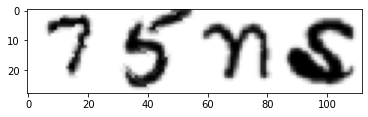

[ 7  5 24 29]


In [ ]:
# show a sample pair of image and label
inde = random.randint(0,number_of_sequences)
# print(inde)
print('shape',dataset_sequences[inde].shape)
plt.imshow(dataset_sequences[inde],cmap='binary')
plt.title('Image')
plt.show()
print('Label\n',dataset_labels[inde])

#Dataloader

In [ ]:
dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,[int(len(seq_dataset) * 0.9), int(len(seq_dataset) * 0.1)])  #split 80% to be train; 20% to be valid

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

#Model

In [ ]:
'''WARNING: 
  Make sure cnn_output_height is correctly computed before feeding into GRU
  Make it bidirectional, or bi-LSTM'''
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

#Tensor Flow Styled summary

In [ ]:
from torchsummary import summary
model = CRNN().to(gpu)
summary(model,(1,28,112)) #h,w

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 26, 110]             320
    InstanceNorm2d-2          [-1, 32, 26, 110]               0
            Conv2d-3           [-1, 32, 12, 54]           9,248
    InstanceNorm2d-4           [-1, 32, 12, 54]               0
            Conv2d-5           [-1, 64, 10, 52]          18,496
    InstanceNorm2d-6           [-1, 64, 10, 52]               0
            Conv2d-7            [-1, 64, 4, 25]          36,928
    InstanceNorm2d-8            [-1, 64, 4, 25]               0
               GRU-9  [[-1, 25, 256], [-1, 2, 128]]               0
           Linear-10                   [-1, 37]           9,509
           Linear-11                   [-1, 37]           9,509
Total params: 84,010
Trainable params: 84,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forwar

#Define Loss and Optimizer

In [ ]:
model = CRNN().to(gpu)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)  # has to use CTC loss here since we want to derive text output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Train Loop

In [ ]:
epochs = 150  # depend on input sequence size. Longer input sequences, more epochs
loss_lst=[]
for _ in range(epochs):
    train_correct = 0
    train_total = 0
    model.train()

    for x_train, y_train in tqdm(train_loader,position=0, leave=True,file=sys.stdout):
        # print(x_train.shape, y_train)
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])

        # print(x_train.shape)
        optimizer.zero_grad()  #clear gradient garbage
        y_pred = model(x_train.cuda())
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11]) convert to [32,64,11]
        # print(y_pred[0])

        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)    #fill the tensor with length
        # print(input_lengths)
        target_lengths = torch.IntTensor([len(t) for t in y_train])           #length of each label sequence in y_train
        # print(target_lengths)
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss_lst.append(loss.item())
        loss.backward()
        optimizer.step()

        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])    #most likely prediction of label
        # print(max_index)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32        #raw prediction list
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])        #conver list to Int Tensor for comparison 

            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):    #if prediction and traget matches, correect+=1
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

100%|██████████| 225/225 [00:06<00:00, 33.68it/s] 
TRAINING. Correct:  0 / 900 = 0.0
100%|██████████| 225/225 [00:01<00:00, 126.19it/s]
TRAINING. Correct:  0 / 900 = 0.0
100%|██████████| 225/225 [00:01<00:00, 124.50it/s]
TRAINING. Correct:  0 / 900 = 0.0
100%|██████████| 225/225 [00:01<00:00, 124.61it/s]
TRAINING. Correct:  20 / 900 = 0.022222222222222223
100%|██████████| 225/225 [00:01<00:00, 125.98it/s]
TRAINING. Correct:  80 / 900 = 0.08888888888888889
100%|██████████| 225/225 [00:01<00:00, 125.27it/s]
TRAINING. Correct:  273 / 900 = 0.30333333333333334
100%|██████████| 225/225 [00:01<00:00, 126.12it/s]
TRAINING. Correct:  472 / 900 = 0.5244444444444445
100%|██████████| 225/225 [00:01<00:00, 123.34it/s]
TRAINING. Correct:  636 / 900 = 0.7066666666666667
100%|██████████| 225/225 [00:01<00:00, 122.47it/s]
TRAINING. Correct:  772 / 900 = 0.8577777777777778
100%|██████████| 225/225 [00:01<00:00, 124.92it/s]
TRAINING. Correct:  841 / 900 = 0.9344444444444444
100%|██████████| 225/225 [00:

# Clear Cache(optional)

In [ ]:
'''WARNING: 
  DO NOT comment out and run these lines, unless reach the RAM limitation'''

# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

'WARNING: \n  DO NOT comment out and run these lines, unless reach the RAM limitation'

#Validation

In [ ]:
val_correct = 0
val_total = 0
for x_val, y_val in tqdm(val_loader,
                          position=0, leave=True,
                          file=sys.stdout):
    batch_size = x_val.shape[0]
    x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])

    y_pred = model(x_val.cuda())
    y_pred = y_pred.permute(1, 0, 2)

    input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
    target_lengths = torch.IntTensor([len(t) for t in y_val])

    criterion(y_pred, y_val, input_lengths, target_lengths)
    _, max_index = torch.max(y_pred, dim=2)
    for i in range(batch_size):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
        if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
            val_correct += 1
        val_total += 1
print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

100%|██████████| 100/100 [00:00<00:00, 334.82it/s]
TESTING. Correct:  33 / 100 = 0.33


#Test

In [ ]:
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)

test_preds = []

(x_test, y_test) = next(iter(test_loader)) #iterator just like for loop

y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda()) #feed test data to model and get prediction result
y_pred = y_pred.permute(1, 0, 2)

_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

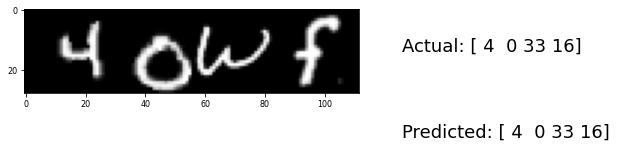

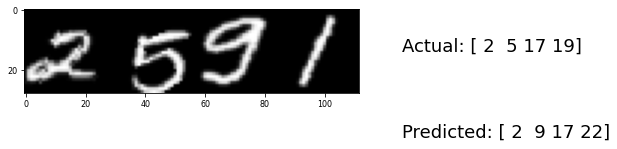

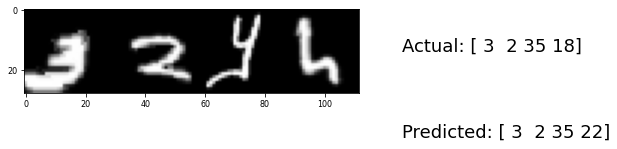

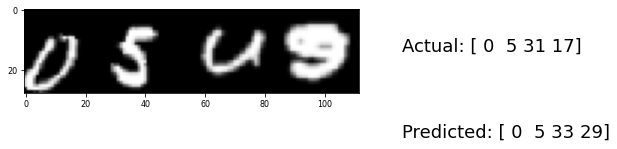

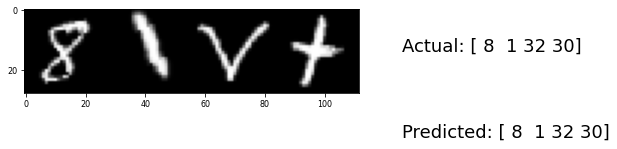

In [ ]:
for j in range(5): #len(x_test)
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=1, y=0.5, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()

# Encode, Decode class

In [ ]:
# import collections
# class strLabelConverter(object):
#     """Convert between str and label.
#     NOTE:
#         Insert `blank` to the alphabet for CTC.
#     Args:
#         alphabet (str): set of the possible characters.
#         ignore_case (bool, default=True): whether or not to ignore all of the case.
#     """

#     def __init__(self, alphabet, ignore_case=True):
#         self._ignore_case = ignore_case
#         if self._ignore_case:
#             alphabet = alphabet.lower()
#         self.alphabet = alphabet + '-'  # for `-1` index

#         self.dict = {}
#         for i, char in enumerate(alphabet):
#             # NOTE: 0 is reserved for 'blank' required by wrap_ctc
#             self.dict[char] = i + 1

#     def encode(self, text):
#         """Support batch or single str.
#         Args:
#             text (str or list of str): texts to convert.
#         Returns:
#             torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
#             torch.IntTensor [n]: length of each text.
#         """
#         if isinstance(text, str):
#             text = [
#                 self.dict[char.lower() if self._ignore_case else char]
#                 for char in text
#             ]
#             length = [len(text)]
#         elif isinstance(text, collections.Iterable):
#             length = [len(s) for s in text]
#             text = ''.join(text)
#             text, _ = self.encode(text)
#         return (torch.IntTensor(text), torch.IntTensor(length))

#     def decode(self, t, length, raw=False):
#         """Decode encoded texts back into strs.
#         Args:
#             torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
#             torch.IntTensor [n]: length of each text.
#         Raises:
#             AssertionError: when the texts and its length does not match.
#         Returns:
#             text (str or list of str): texts to convert.
#         """
#         if length.numel() == 1:
#             length = length[0]
#             assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
#             if raw:
#                 return ''.join([self.alphabet[i - 1] for i in t])
#             else:
#                 char_list = []
#                 for i in range(length):
#                     if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
#                         char_list.append(self.alphabet[t[i] - 1])
#                 return ''.join(char_list)
#         else:
#             # batch mode
#             assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
#             texts = []
#             index = 0
#             for i in range(length.numel()):
#                 l = length[i]
#                 texts.append(
#                     self.decode(
#                         t[index:index + l], torch.IntTensor([l]), raw=raw))
#                 index += l
#             return texts

In [ ]:
# test case

# alphabet = '0123456789abcdefghijklmnopqrstuvwxyz'
# encoder=strLabelConverter(alphabet)
# result = encoder.encode('starbucks')
# print(result)

(tensor([29, 30, 11, 28, 12, 31, 13, 21, 29], dtype=torch.int32), tensor([9], dtype=torch.int32))
